In [0]:
%matplotlib inline


Training a Neural Network
=====================

This Learning Lab is adapted from the [Pytorch: A 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html). You can find additional help and resources there.

In this Learning Lab, you will learn how to

1. Load and normalize the CIFAR10 training and test datasets using ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data
6. Make modifications to improve the network


# 1. Starting with Data
----------------------

Pytorch is generally setup so that you can use standard python packages that load data into a numpy array.
Once you have the array, you can simply into convert it into a Pytorch's native ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, there is a whole set of useful functions inside the package ``torchvision``.
It has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.
This provides a huge convenience and avoids writing boilerplate code.

For this Learning Lab, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
32x32 with  3-channel color.
Examples of such images can be found [here](https://storage.googleapis.com/kaggle-competitions/kaggle/3649/media/cifar-10.png).

**Note: Pytorch defines data with channel dimension first (i.e. ch, rows, cols). 
Thus, CIFAR-10 images are a 3x32x32 tensor.
This is different than how we generally think about images in Numpy (i.e. rows, cols, ch)**

If we are using torchvision data, the loading process is very easy.

In [0]:
import torch
import torchvision

Before we load the data, we want to tell Pytorch that we want to normalize the images.
The output of torchvision datasets are PILImage images of range [0, 1].
Instead, we will define a transform that will normalize the range to [-1, 1].


In [0]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

Now we can load the data with the appropriate transform. Note: this may take up some space in your Google Drive.

In [4]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



 ship   car truck  bird


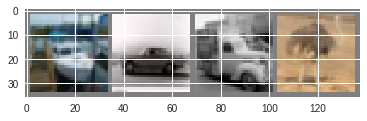

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 2. Define a Convolution Neural Network
----------------------------------------

The next step is to design the network that will be learning how to classify the images. A network is designed of many, many weights that are individually manipulated to get closer to a desired outcome. For simplicity, we can think of these weights in the network in terms of structural layers. Here are the two main layers of a network we will need:

- **Convolutional Layers**: These layers act as sliding widows across an image and learn to extract useful information from the image (think of a learned version of SIFT).

- **Fully Connected Layers**: These layers gather all the features extracted from the convolutional layers and use them to categorize features together. They are also used as the last layer to determine the final categorization of the image.

Additionally, we will need two more important structures in a neural network:

- **Pooling Layers**: These layers don't have any learned weights, but instead are used to resize the output of the network. In this case, we are using ``MaxPool2d``, which takes the maximum value from a grouping of features. This can be useful for reducing noise.

- **Nonlinear Functions**: We don't have time to go into detail here, but nonlinear functions are the whole reason neural networks can be so deep. A nonlinear function is applied to output of each learned layer of the network. In this case, we are using ``relu`` which allows the network to zero-out features it doesn't think will be useful.


Now that we know all the possible layers, let's design the network. It is going to have two convolutional layers, three fully connected layers, it will use max pooling, and ReLU's as the nonlinear function. We define all our layers first in the ``__init__`` method, then we describe how they are connected in the ``forward`` method.

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) #(number of input channels, number of output channels, stride of sliding window)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #(number of input channels, number of output channels)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(2, 2) #(region size to pool (2x2), stride of sliding window)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # Reshape the features into a 1D array before feeding them into the Fully Connected Layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

If you are wondering how all these numbers are decided for input and output sizes, the short answer is that there really isn't a correct answer to how these are determined.
The main three things that must be true are this:

1. The input size into the first layer needs to match the number of channels that are present in the input data (in this case, it is 3 for the RGB data we are feeding in).
2. The output size of a layer needs to match the input size of the next layer.
3. The output size of the last layer must match number of categories you are trying to predict (in this case, 10 for the ten possible categories in CIFAR-10).

Designing a network with the right number of layers that are the right size is a skill you will learn the more you practice deep learning.

Now that we have a network designed, we now need to instantiate it.

In [0]:
net = Net()

# 3. Define a Loss Function and Optimizer
---------------------------------------
In order for the network to learn, it needs to know when it has done well and when it has done poorly. This is the purpose of the loss function. For our purposes, we will use Cross Entropy Loss. It has some sophisticated calculations, but essentially it penalizes the network when it categorizes an image wrong and it rewards when it categorizes it right.




In [0]:
loss_fn = nn.CrossEntropyLoss()

Additionally, we need something to change the weights of the network once it knows how it did. This is accomplished through the optimizer. Two standard optimizers are Stochastic Gradient Descent (SGD) and the Adam optimizer. For this lab, we will use SGD.

In [0]:
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4. Train the Network
--------------------------------------

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize. The code below follows standard practice for most training algorithms.



In [10]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.242
[1,  4000] loss: 1.871
[1,  6000] loss: 1.697
[1,  8000] loss: 1.609
[1, 10000] loss: 1.545
[1, 12000] loss: 1.477
[2,  2000] loss: 1.406
[2,  4000] loss: 1.392
[2,  6000] loss: 1.351
[2,  8000] loss: 1.325
[2, 10000] loss: 1.298
[2, 12000] loss: 1.281
Finished Training


# 5. Test the Network on the Test Data
----------------------------------------------------------------

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learned anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


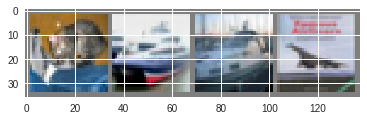

In [11]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
outputs = net(images)

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [13]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learned something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 49 %
Accuracy of   car : 66 %
Accuracy of  bird : 56 %
Accuracy of   cat : 33 %
Accuracy of  deer : 32 %
Accuracy of   dog : 37 %
Accuracy of  frog : 73 %
Accuracy of horse : 62 %
Accuracy of  ship : 77 %
Accuracy of truck : 65 %


So the network learned pretty well, but we can probably do better, especially in certain categories.

For the rest of the learning lab, complete the exercises below to learn how to make a network run faster and learn better.

# Exercises
----------------------------------------

## Batch Size

One hyperparameter that needs to be tuned is batch size. When we made our dataloader, we used a batch size of 4. This means that instead of learning on one image at a time, the network is actually pulling in 4 images at a time (i.e. 4x3x32x32 data). We could use a larger or smaller batch size. What affects do you notice when you change the batch size?

## Change the Network Structure

The network design we chose was essentially arbitrary. Would a wider network do better? For example, try changing the width of the first layer (i.e. change argument 2 of the first ``nn.Conv2d``, and argument 1 of the second ``nn.Conv2d`` so that they are larger, but still the same number).

What if we made a deeper network? Try adding another convolution layer into the previously defined network. Remember that you will need to change the ``__init__`` and ``forward`` methods.

## Train for Longer

Training the network for longer might allow it to learn more. This can be done by changing the number of times it goes through the data (what is commonly called epochs). Try changing the number of training epochs for the example above. It might also be helpful to save the training loss over time. That way, you can plot it and see when it stops decreasing.

## Train on a GPU

The benefit of using Google Colab is that you have access to a GPU. Right now, the network is only defined to run on a CPU, but with some simple modifications, you can greatly increase the speed of a network by allowing to run on a GPU.

**Note: You may need to enable the GPU and rerun the notebook. Click Edit>Notebook Settings>Hardware Accelerator>GPU**

The first thing we need to do is check if we have access to a GPU that runs CUDA:



In [3]:
torch.cuda.is_available()

True

If it is available, we want to move our network and our data to the GPU so the training can run having to move data. This can be done with a call that might look like this:


In [0]:
if torch.cuda.is_available():
    net.cuda()
    
# Later in training loop
if torch.cuda.is_available():
    inputs = inputs.cuda()
    labels = labels.cuda()
    

Alternatively,

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

# Later in training loop
inputs, labels = inputs.to(device), labels.to(device)

Now your network and data should be running on the GPU, which should make it much faster on a larger network. However, remember that if you ever want to visualize your results or save them, you will need to bring the values back to the CPU, which can be done with a simple ``data.cpu()`` call.



## Goals achieved

- Understanding PyTorch's Tensor library and neural networks at a high level
- Training a small neural network to classify images
- Learning to modify networks to improve them

